In [4]:
import pandas as pd
from bs4 import BeautifulSoup
import requests
pd.set_option('display.max_columns', None)
import numpy as np
from time import sleep
from IPython.display import clear_output
import matplotlib.pyplot as plt

In [5]:
# Define team abbreviation to name map dictionnary
team_dic = {'Syracuse Nationals': 'SYR','Buffalo Braves': 'BUF','New York Nets': 'NYN','Cincinnati Royals': 'CIN','Kansas City-Omaha Kings': 'KCO',
    'Capital Bullets': 'CAP','Sacramento Kings': 'SAC','Seattle SuperSonics': 'SEA','Los Angeles Clippers': 'LAC','Washington Wizards': 'WAS',
    'New Orleans/Oklahoma City Hornets': 'NOK','Phoenix Suns': 'PHO','New Jersey Nets': 'NJN','Washington Bullets': 'WSB','Boston Celtics': 'BOS',
    'Golden State Warriors': 'GSW','Denver Nuggets': 'DEN','Vancouver Grizzlies': 'VAN','Orlando Magic': 'ORL','Chicago Bulls': 'CHI','Utah Jazz': 'UTA',
    'Toronto Raptors': 'TOR','Los Angeles Lakers': 'LAL','Portland Trail Blazers': 'POR','Memphis Grizzlies': 'MEM','Miami Heat': 'MIA',
    'New Orleans Hornets': 'NOH','San Diego Rockets': 'SDR','Atlanta Hawks': 'ATL','Oklahoma City Thunder': 'OKC','Philadelphia Warriors': 'PHW',
    'Milwaukee Bucks': 'MIL','New Orleans Jazz': 'NOJ','San Antonio Spurs': 'SAS','Charlotte Hornets': 'CHO','Brooklyn Nets': 'BRK',
    'Cleveland Cavaliers': 'CLE','San Diego Clippers': 'SDC','San Francisco Warriors': 'SFW','Rochester Royals': 'ROC','Philadelphia 76ers': 'PHI',
    'Houston Rockets': 'HOU','Fort Wayne Pistons': 'FTW','Dallas Mavericks': 'DAL','New York Knicks': 'NYK','Kansas City Kings': 'KCK',
    'Indiana Pacers': 'IND','St. Louis Hawks': 'STL','Baltimore Bullets': 'BAL','Detroit Pistons': 'DET','Minnesota Timberwolves': 'MIN','New Orleans Pelicans': 'NOP',
    'Chicago Packers': 'CHP','Charlotte Bobcats': 'CHA','Chicago Zephyrs': 'CHZ','Minneapolis Lakers': 'MNL','Charlotte Hornets\xa0': 'CHO'}

In [20]:
monthly_data = []
for month in ['october', 'november', 'december', 'january', 'february', 'march', 'april', 'may', 'june']:

    url = f'https://www.basketball-reference.com/leagues/NBA_2022_games-{month}.html'
    soup = BeautifulSoup(requests.get(url).content, 'html')
    df = pd.read_html(str(soup.find('table')))[0][['Date', 'Home/Neutral', 'Visitor/Neutral', 'PTS.1', 'PTS']]
    df = df.rename(columns = {'Visitor/Neutral': 'Away_name', 'Home/Neutral': 'Home_name', 'PTS': 'PTS_away', 'PTS.1': 'PTS_home'})
    monthly_data.append(df)
    sleep(2)

data_all = pd.concat(monthly_data)
data_all['Date'] = pd.to_datetime(data_all['Date'])
data_all['Home'] = data_all['Home_name'].apply(lambda x: team_dic.get(x))
data_all['Away'] = data_all['Away_name'].apply(lambda x: team_dic.get(x))

data_all['ID'] = data_all['Date'].apply(lambda x: str(x)[2:10].replace('-', '')) + data_all['Home'] + data_all['Away']
data_all['PTS_diff'] = data_all['PTS_home'] - data_all['PTS_away']
#data_all = data_all[['ID', 'Date', 'Home', 'Away', 'PTS_home', 'PTS_away', 'Home_name', 'Away_name', 'PTS_diff']]

data_all.head()
    

ImportError: html5lib not found, please install it

In [18]:
data_team_home = []
data_team_away = []
for step, team in enumerate(set(data_all['Home'])) :

    sleep(2)

    url = f'https://www.basketball-reference.com/teams/{team}/2022_games.html'
    page = requests.get(url)
    clear_output(wait = True)
    print(str(step+1) + '/30 ... ', team, page)

    soup = BeautifulSoup(page.content, 'html')
    while soup.find('tr', class_='thead') is not None:
        soup.find('tr', class_='thead').decompose()
    table = soup.find('table')

    df = pd.read_html(str(table))[0]
    df = df[df['Notes'] != 'Play-In Game']
    df = df.drop(columns = ['Start (ET)', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 8', 'W', 'L', 'Notes'])
    df = df.rename(columns = {'Tm': 'PTS', 'Opp': 'PTS_opp', 'Unnamed: 7' : 'W', 'Unnamed: 5': 'Venue'})

    df['Team'] = len(df) * [team]
    df['W'] = df['W'].replace('W', 1).replace('L', 0)
    df['Date'] = pd.to_datetime(df['Date'])
    df['Opponent'] = df['Opponent'].apply(lambda x: team_dic.get(x))
    df['Venue'] = df['Venue'].replace(np.nan, 1).replace('@', 0)

    def streak(str):
        wl, n = str.split()
        if wl == 'W':
            return int(n)
        if wl == 'L':
            return -int(n)
    df['Streak'] = df['Streak'].apply(streak)
    df['Streak'] = [np.nan] + list(df['Streak'])[:-1]

    for stat, underlying_stat in zip(['W/L%', 'ORtg', 'DRtg'], ['W', 'PTS', 'PTS_opp']):
        
        df[stat] = [np.nan] + list(df[underlying_stat].rolling(1000, min_periods = 1).mean())[:-1]
        for w in [1, 2, 5, 10, 25]:
            df[stat + '_' + str(w)] = [np.nan] + list(df[underlying_stat].rolling(w, min_periods = 1).mean())[:-1]

    df['NRtg'] = df['ORtg'] - df['DRtg']
    df['NRtg_1'] = df['ORtg_1'] - df['DRtg_1']
    df['NRtg_2'] = df['ORtg_2'] - df['DRtg_2']
    df['NRtg_5'] = df['ORtg_5'] - df['DRtg_5']
    df['NRtg_10'] = df['ORtg_10'] - df['DRtg_10']
    df['NRtg_25'] = df['ORtg_25'] - df['DRtg_25']

    df_home = df.groupby('Venue').get_group(1)
    df_home = df_home.drop(columns = ['Venue'])
    for col in list(df_home):
        df_home = df_home.rename(columns = {col: col + '_home'})
    df_home = df_home.rename(columns = {'Date_home': 'Date', 'Opponent_home': 'Away', 'PTS_opp_home': 'PTS_away', 'Team_home': 'Home'})
    df_home['ID'] = df_home['Date'].apply(lambda x: str(x)[2:10].replace('-', '')) + df_home['Home'] + df_home['Away']

    df_away = df.groupby('Venue').get_group(0)
    df_away = df_away.drop(columns = ['Venue'])
    for col in list(df_away):
        df_away = df_away.rename(columns = {col: col + '_away'})
    df_away = df_away.rename(columns = {'Date_away': 'Date', 'Opponent_away': 'Home', 'PTS_opp_away': 'PTS_home', 'Team_away': 'Away'})
    df_away['ID'] = df_away['Date'].apply(lambda x: str(x)[2:10].replace('-', '')) + df_away['Home'] + df_away['Away']

    data_team_home.append(df_home)
    data_team_away.append(df_away)

homes = pd.concat(data_team_home)
aways = pd.concat(data_team_away)
    

data = homes.merge(aways, on = ['ID', 'Date', 'Home', 'Away', 'PTS_home', 'PTS_away'])
data['PTS_diff'] = data['PTS_home'] - data['PTS_away']
data = data.sort_values('Date').reset_index(drop = True)

features = [x for x in list(data) if 'W/L%' in x or 'ORtg' in x or 'DRtg' in x or 'Streak' in x]
data = data[['ID', 'Date', 'G_home', 'G_away', 'Home', 'Away', 'W_home', 'PTS_home', 'PTS_away', 'PTS_diff'] + features]


1/30 ...  CHI <Response [429]>


ImportError: html5lib not found, please install it

In [8]:
url

'https://www.basketball-reference.com/teams/CHI/2022_games.html'

In [428]:
def data_scrape_year(year, save = False):

    def streak(str):
            wl, n = str.split()
            if wl == 'W':
                return int(n)
            if wl == 'L':
                return -int(n)

    ### SCRAPE THE DATA "SKELETON" ###

    monthly_data = []
    for month in ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december']:

        if year == 2020 and month == 'october':
                url = f'https://www.basketball-reference.com/leagues/NBA_{year}_games-{month}-{year-1}.html'
        else :
            url = f'https://www.basketball-reference.com/leagues/NBA_{year}_games-{month}.html'
        if requests.get(url).status_code == 200:
            clear_output(wait = True)
            print(f'{year} ... Scraping data skeleton ... {month} ...')
            soup = BeautifulSoup(requests.get(url).content, 'html')
            df = pd.read_html(str(soup.find('table')))[0][['Date', 'Home/Neutral', 'Visitor/Neutral', 'PTS.1', 'PTS']]
            df = df.rename(columns = {'Visitor/Neutral': 'Away_name', 'Home/Neutral': 'Home_name', 'PTS': 'PTS_away', 'PTS.1': 'PTS_home'})
            monthly_data.append(df)
        sleep(3)

    data_all = pd.concat(monthly_data)
    data_all = data_all[data_all['Date'] != 'Playoffs']
    data_all['Date'] = pd.to_datetime(data_all['Date'])
    data_all['Home'] = data_all['Home_name'].apply(lambda x: team_dic.get(x))
    data_all['Away'] = data_all['Away_name'].apply(lambda x: team_dic.get(x))

    data_all['ID'] = data_all['Date'].apply(lambda x: str(x)[2:10].replace('-', '')) + data_all['Home'] + data_all['Away']
    data_all[['PTS_home', 'PTS_away']] = data_all[['PTS_home', 'PTS_away']].apply(pd.to_numeric, errors = 'ignore')
    data_all['PTS_diff'] = data_all['PTS_home'] - data_all['PTS_away']
    #data_all = data_all[['ID', 'Date', 'Home', 'Away', 'PTS_home', 'PTS_away', 'Home_name', 'Away_name', 'PTS_diff']]

    data_all.head()

    ### SCRAPE SCHEDULE OF EACH TEAM ###

    # Initiate list for all home and away games
    data_team_home = []
    data_team_away = []
    n_teams = len(set(data_all['Home']))
    for step, team in enumerate(set(data_all['Home'])) : # Loop for every team

        clear_output(wait = True)
        print(f'{year} ... {step+1}/{n_teams} ... {team}')
        sleep(3) # Avoid getting rate limited by BR

        url = f'https://www.basketball-reference.com/teams/{team}/{year}_games.html'

        soup = BeautifulSoup(requests.get(url).content, 'html')
        while soup.find('tr', class_='thead') is not None: # Decompose all headers
            soup.find('tr', class_='thead').decompose()

        # Create schedule DataFrame
        df = pd.read_html(str(soup.find('table')))[0]
        df = df[df['Notes'] != 'Play-In Game']
        df = df.drop(columns = ['Start (ET)', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 8', 'W', 'L', 'Notes'])
        df = df.rename(columns = {'Tm': 'PTS', 'Opp': 'PTS_opp', 'Unnamed: 7' : 'W', 'Unnamed: 5': 'Venue'})

        df['Team'] = len(df) * [team]
        df['W'] = df['W'].replace('W', 1).replace('L', 0)
        df['Date'] = pd.to_datetime(df['Date'])
        df['Opponent'] = df['Opponent'].apply(lambda x: team_dic.get(x))
        df['Venue'] = df['Venue'].replace(np.nan, 1).replace('@', 0)

        df['Streak'] = df['Streak'].apply(streak)
        df['Streak'] = [np.nan] + list(df['Streak'])[:-1]

        for stat, underlying_stat in zip(['W/L%', 'ORtg', 'DRtg'], ['W', 'PTS', 'PTS_opp']):
            
            df[stat] = [np.nan] + list(df[underlying_stat].rolling(1000, min_periods = 1).mean())[:-1]
            for w in [1, 2, 5, 10, 25]:
                df[stat + '_' + str(w)] = [np.nan] + list(df[underlying_stat].rolling(w, min_periods = 1).mean())[:-1]

        df['NRtg'] = df['ORtg'] - df['DRtg']
        df['NRtg_1'] = df['ORtg_1'] - df['DRtg_1']
        df['NRtg_2'] = df['ORtg_2'] - df['DRtg_2']
        df['NRtg_5'] = df['ORtg_5'] - df['DRtg_5']
        df['NRtg_10'] = df['ORtg_10'] - df['DRtg_10']
        df['NRtg_25'] = df['ORtg_25'] - df['DRtg_25']

        df_home = df.groupby('Venue').get_group(1)
        df_home = df_home.drop(columns = ['Venue'])
        for col in list(df_home):
            df_home = df_home.rename(columns = {col: col + '_home'})
        df_home = df_home.rename(columns = {'Date_home': 'Date', 'Opponent_home': 'Away', 'PTS_opp_home': 'PTS_away', 'Team_home': 'Home'})
        df_home['ID'] = df_home['Date'].apply(lambda x: str(x)[2:10].replace('-', '')) + df_home['Home'] + df_home['Away']

        df_away = df.groupby('Venue').get_group(0)
        df_away = df_away.drop(columns = ['Venue'])
        for col in list(df_away):
            df_away = df_away.rename(columns = {col: col + '_away'})
        df_away = df_away.rename(columns = {'Date_away': 'Date', 'Opponent_away': 'Home', 'PTS_opp_away': 'PTS_home', 'Team_away': 'Away'})
        df_away['ID'] = df_away['Date'].apply(lambda x: str(x)[2:10].replace('-', '')) + df_away['Home'] + df_away['Away']

        data_team_home.append(df_home)
        data_team_away.append(df_away)

    ### BRING DATA ALL TEAMS TOGETHER ###

    # Get all home stats and away stats in single DataFrame
    homes = pd.concat(data_team_home)
    aways = pd.concat(data_team_away)
        
    # Merge away and home games on the unique game ID
    data = homes.merge(aways, on = ['ID', 'Date', 'Home', 'Away', 'PTS_home', 'PTS_away'])
    data['PTS_diff'] = data['PTS_home'] - data['PTS_away']
    data = data.sort_values('Date').reset_index(drop = True)

    features = [x for x in list(data) if 'W/L%' in x or 'ORtg' in x or 'DRtg' in x or 'Streak' in x]
    data = data[['ID', 'Date', 'G_home', 'G_away', 'Home', 'Away', 'W_home', 'PTS_home', 'PTS_away', 'PTS_diff'] + features]

    if save:
        data.to_csv(f'training_data/data_{year}.csv', index = None)

    return data

In [429]:
for year in [2019, 2018, 2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010]:
    data = data_scrape_year(year, save = True)

2010 ... 30/30 ... SAC


In [431]:
data_train = pd.concat([pd.read_csv('training_data/data_2010.csv'), pd.read_csv('training_data/data_2011.csv'),
            pd.read_csv('training_data/data_2012.csv'), pd.read_csv('training_data/data_2013.csv'),
            pd.read_csv('training_data/data_2014.csv'), pd.read_csv('training_data/data_2015.csv'),
            pd.read_csv('training_data/data_2016.csv'), pd.read_csv('training_data/data_2017.csv'),
            pd.read_csv('training_data/data_2018.csv'), pd.read_csv('training_data/data_2019.csv'),
            pd.read_csv('training_data/data_2020.csv'), pd.read_csv('training_data/data_2021.csv'),
            pd.read_csv('training_data/data_2022.csv')])

data_train.to_csv('training_data/training_data.csv', index = None)

In [433]:
corr_df = data[features + ['NRtg'] + ['PTS_diff']].corr().sort_values('PTS_diff', ascending = False)[1:]

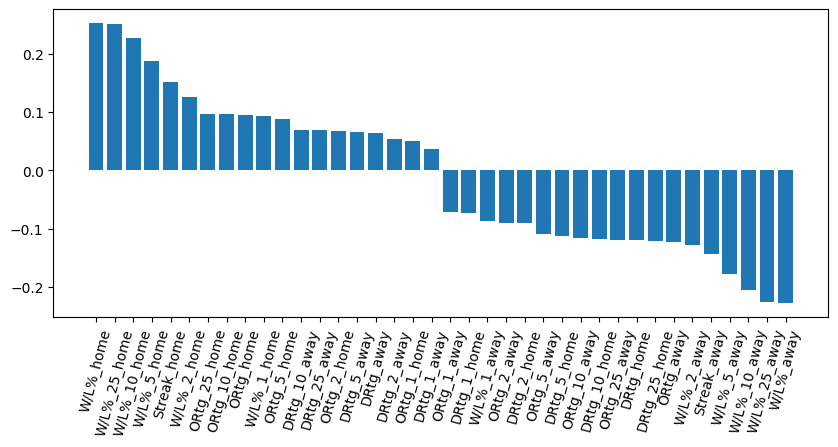

In [434]:
plt.figure(figsize = (10, 4))
plt.bar(corr_df.index, corr_df['PTS_diff'])
plt.xticks(rotation = 75)
plt.show()

In [414]:
data_all

,Date,Home_name,Away_name,PTS_home,PTS_away,Home,Away,ID
0,"Tue, Jan 1, 2019",Toronto Raptors,Utah Jazz,122,116,TOR,UTA,"e, Jan 1TORUTA"
1,"Tue, Jan 1, 2019",Milwaukee Bucks,Detroit Pistons,121,98,MIL,DET,"e, Jan 1MILDET"
2,"Tue, Jan 1, 2019",Denver Nuggets,New York Knicks,115,108,DEN,NYK,"e, Jan 1DENNYK"
3,"Tue, Jan 1, 2019",Sacramento Kings,Portland Trail Blazers,108,113,SAC,POR,"e, Jan 1SACPOR"
4,"Tue, Jan 1, 2019",Los Angeles Clippers,Philadelphia 76ers,113,119,LAC,PHI,"e, Jan 1LACPHI"
...,...,...,...,...,...,...,...,...
214,"Mon, Dec 31, 2018",Houston Rockets,Memphis Grizzlies,113,101,HOU,MEM,"n, Dec 3HOUMEM"
215,"Mon, Dec 31, 2018",San Antonio Spurs,Boston Celtics,120,111,SAS,BOS,"n, Dec 3SASBOS"
216,"Mon, Dec 31, 2018",New Orleans Pelicans,Minnesota Timberwolves,123,114,NOP,MIN,"n, Dec 3NOPMIN"
217,"Mon, Dec 31, 2018",Oklahoma City Thunder,Dallas Mavericks,122,102,OKC,DAL,"n, Dec 3OKCDAL"


In [427]:
data_all = data_all[data_all['Date'] != 'Playoffs']
data_all['Date'] = pd.to_datetime(data_all['Date'])
data_all['Home'] = data_all['Home_name'].apply(lambda x: team_dic.get(x))
data_all['Away'] = data_all['Away_name'].apply(lambda x: team_dic.get(x))
data_all[['PTS_home', 'PTS_away']] = data_all[['PTS_home', 'PTS_away']].apply(pd.to_numeric, errors = 'ignore')
data_all['ID'] = data_all['Date'].apply(lambda x: str(x)[2:10].replace('-', '')) + data_all['Home'] + data_all['Away']
#data_all['PTS_diff'] = data_all['PTS_home'] - data_all['PTS_away']
#data_all = data_all[['ID', 'Date', 'Home', 'Away', 'PTS_home', 'PTS_away', 'Home_name', 'Away_name', 'PTS_diff']]

data_all.head()

,Date,Home_name,Away_name,PTS_home,PTS_away,Home,Away,ID
0,2019-01-01,Toronto Raptors,Utah Jazz,122.0,116.0,TOR,UTA,190101TORUTA
1,2019-01-01,Milwaukee Bucks,Detroit Pistons,121.0,98.0,MIL,DET,190101MILDET
2,2019-01-01,Denver Nuggets,New York Knicks,115.0,108.0,DEN,NYK,190101DENNYK
3,2019-01-01,Sacramento Kings,Portland Trail Blazers,108.0,113.0,SAC,POR,190101SACPOR
4,2019-01-01,Los Angeles Clippers,Philadelphia 76ers,113.0,119.0,LAC,PHI,190101LACPHI


In [441]:
import keras

SyntaxError: invalid syntax (pywrap_tensorflow_internal.py, line 114)

In [29]:
url ='https://www.basketball-reference.com/leagues/NBA_2022_games-october.html'

In [30]:
page = requests.get(url)